from:

https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
train_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/train.csv')
test_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/test.csv')
submit_df = pd.read_csv('/kaggle/input/smit-tgt-2023/data/submission_sample.csv')

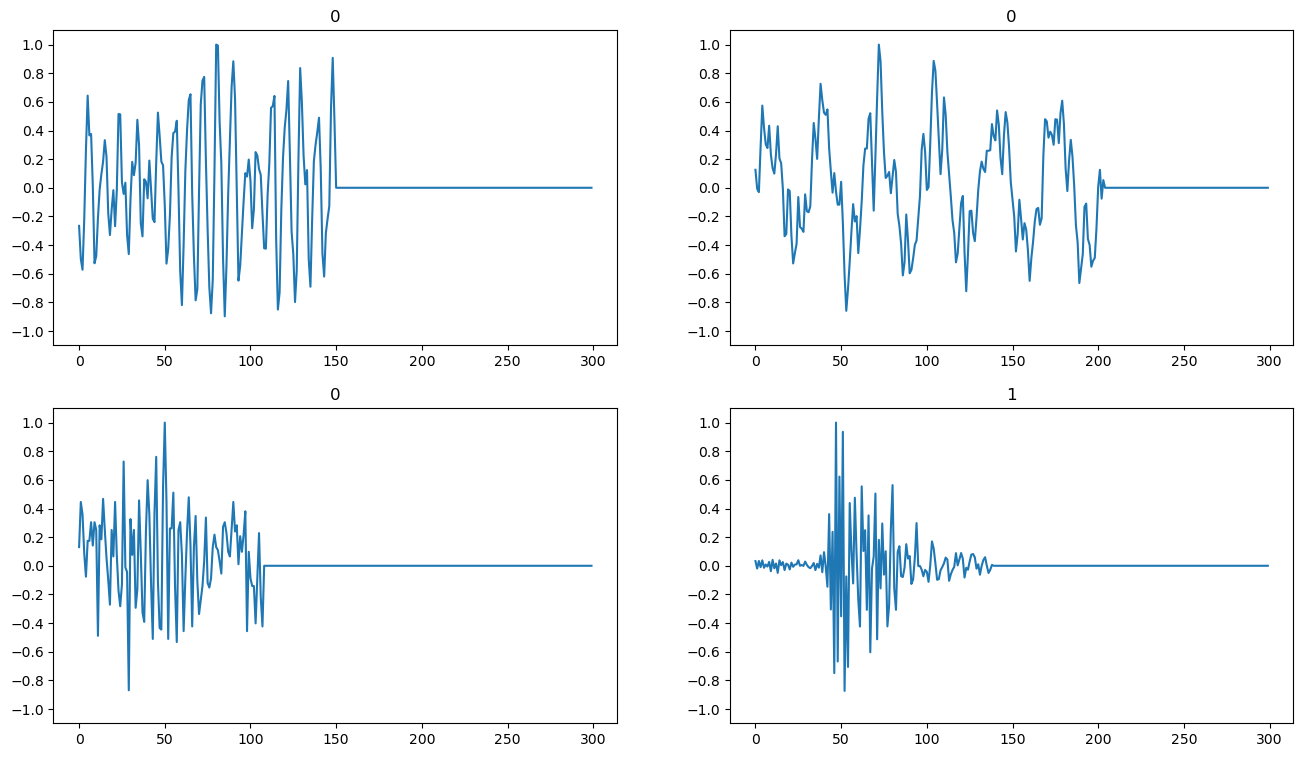

In [3]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(train_df.iloc[i, :-1].fillna(0).values)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = train_df.iloc[i, 300]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [53]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=64, frame_step=16)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [54]:
for i in range(3):
    label = train_df.iloc[i, 300]
    waveform = train_df.iloc[i, :-1].fillna(0).values
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
#     display.display(display.Audio(waveform, rate=117200));

Label: 0
Waveform shape: (300,)
Spectrogram shape: (15, 33, 1)
Audio playback
Label: 0
Waveform shape: (300,)
Spectrogram shape: (15, 33, 1)
Audio playback
Label: 0
Waveform shape: (300,)
Spectrogram shape: (15, 33, 1)
Audio playback


In [6]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

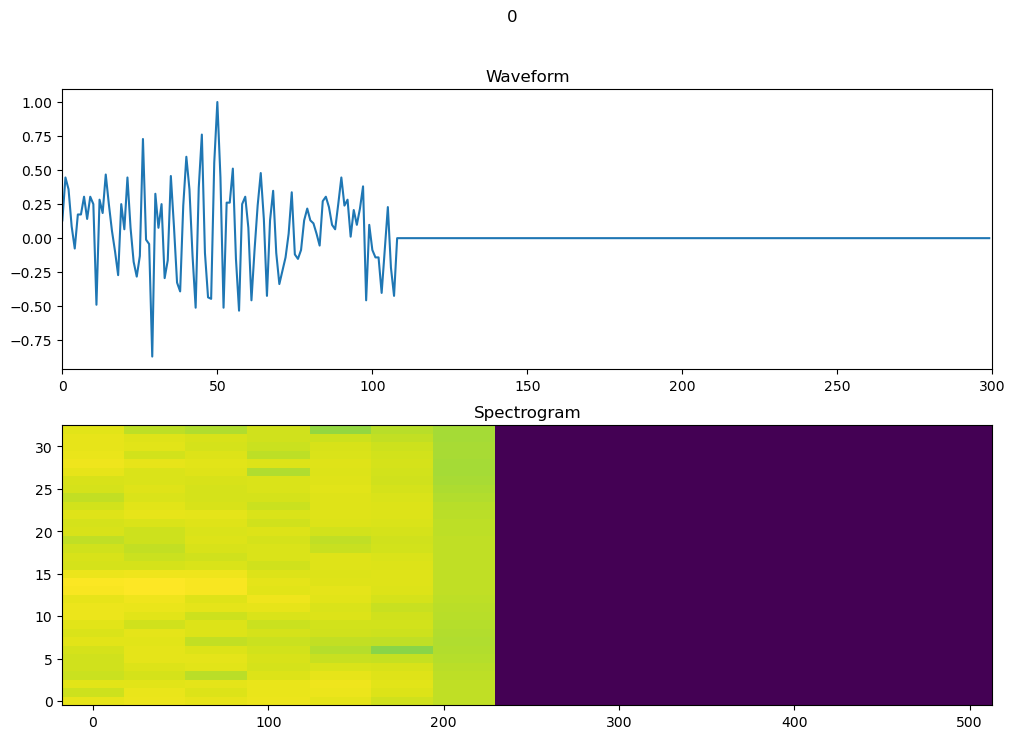

In [55]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 300])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label)
plt.show()

In [70]:
def get_data_example(row):
    return (get_spectrogram(row[:-1]), row[-1])
            
def get_data_example_test(row):
    return get_spectrogram(row)

In [88]:
full_ds = tf.data.Dataset.from_tensor_slices(train_df.fillna(0).values)
full_ds = full_ds.map(get_data_example)

test_ds = full_ds.take(500) 
train_ds = full_ds.skip(500)
print(train_ds.cardinality().numpy(), test_ds.cardinality().numpy())

train_ds = train_ds.batch(256).cache().shuffle(3000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(256).cache().prefetch(tf.data.AUTOTUNE)

submit_ds = tf.data.Dataset.from_tensor_slices((test_df.fillna(0).values))
submit_ds = submit_ds.map(get_data_example_test)
submit_ds = submit_ds.batch(256)
print(train_ds.take(2))

3292 500
<TakeDataset element_spec=(TensorSpec(shape=(None, 15, 33, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


# Model

In [121]:
input_shape = spectrogram.shape
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

Input shape: (15, 33, 1)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_14 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_17 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 flatten_17 (Flatten)       

In [122]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [123]:
EPOCHS = 45
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/45
13/13 [==============================] - 2s 103ms/step - loss: 0.3324 - accuracy: 0.8187 - val_loss: 0.2235 - val_accuracy: 0.8960
Epoch 2/45
13/13 [==============================] - 1s 93ms/step - loss: 0.2139 - accuracy: 0.8782 - val_loss: 0.1795 - val_accuracy: 0.9200
Epoch 3/45
13/13 [==============================] - 1s 93ms/step - loss: 0.1908 - accuracy: 0.9122 - val_loss: 0.1619 - val_accuracy: 0.9320
Epoch 4/45
13/13 [==============================] - 1s 89ms/step - loss: 0.1791 - accuracy: 0.9189 - val_loss: 0.1518 - val_accuracy: 0.9500
Epoch 5/45
13/13 [==============================] - 1s 95ms/step - loss: 0.1730 - accuracy: 0.9198 - val_loss: 0.1461 - val_accuracy: 0.9540
Epoch 6/45
13/13 [==============================] - 1s 96ms/step - loss: 0.1591 - accuracy: 0.9344 - val_loss: 0.1338 - val_accuracy: 0.9520
Epoch 7/45
13/13 [==============================] - 1s 93ms/step - loss: 0.1514 - accuracy: 0.9377 - val_loss: 0.1281 - val_accuracy: 0.9540
Epoch 8/45
1

Text(0, 0.5, 'Accuracy [%]')

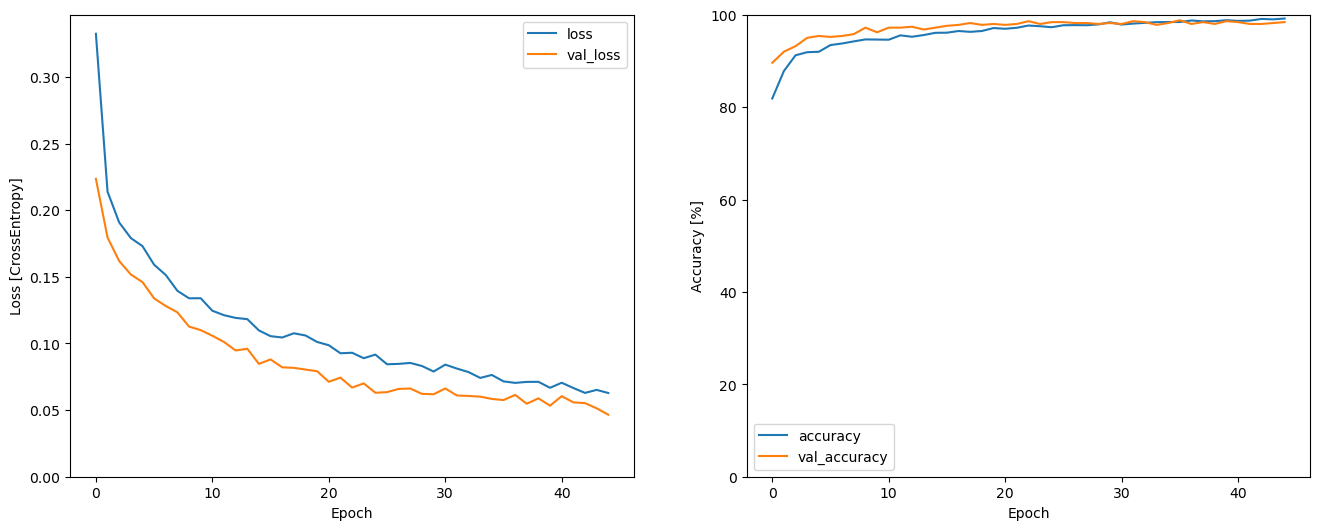

In [124]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Submit

In [125]:
submit_preds = model.predict(submit_ds)

2/2 [==============================] - 0s 20ms/step


In [127]:
submit_df['label'] = tf.where(submit_preds < 0.5, 0, 1).numpy()[:, 0]
submit_df.to_csv('./keras_cnn.csv', index=False)